# Random Effect Logistic Regression by MLMC Variational Bayes

## Model Description

##### Random Effect Models:
For $n=1,2,...$,
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Z_n \sim N(0,\tau^2)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t})}\right)$
<br>
for $t=1, ..., T$. This model carries out dimentionality reduction of binary observations $y_{n,k}$'s. Here, the dimention of $\beta$ and $x_{n,t}$ is $D$.<br>
As variational approximation of the posterior $p(z_n|y_n)$, we use $q(z_n)= N(z_n;\mu_n, \sigma_n^2)$.

To constrain the parameter $\tau^2>0$, we parametrize $\tau^2$ as $\tau^2 = \mathrm{softplus}(\alpha)$, where $\mathrm{softplus}(x) := \log(1+\exp(x))>0$.

##### Possible Extension:

By adding $\bar x_n=\frac{1}{T}\sum_t x_{n,t}$ to the predictors as 
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t}- \gamma\bar x_n)}\right)$,
<br>
we can obtain correlated random effect models.

#### We do not consider the use of Renyi divergences

## Import Packages

In [1]:
# Turn GPUs off
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
from matplotlib import pyplot as plt
import time
import datetime
np.random.seed(0)

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
import sys
sys.path.append('../')
from src.models.random_effect_logistic_regression import random_effect_logistic_regression as RELR
from src.models.random_effect_logistic_regression import bayesian_random_effect_logistic_regression as BRELR

## Utilities

In [5]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))

def timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d%H%M%S")  

## Generate Toy Dataset

In [6]:
N = 1000
D = 3
T = 2

In [7]:
# Paramters
alpha = np.float64(1.)
beta0 = np.float64(0.)
beta  = np.array([0.25, 0.50, 0.75]) #np.random.randn(D) / np.sqrt(D)
param0 = {
    'alpha': alpha,
    'beta0': beta0,
    'beta': beta
}

In [8]:
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, T, beta0, beta, alpha):
    """
    Genarate N samples of data from the model with parameter [beta0, beta, alpha]. 
    Returns:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    """

    z = np.random.randn(N) * softplus(alpha)**(1/2.)
    x = np.random.randn(N*T*D).reshape([N,T,D])
    y = bernoulli(p=sigmoid(beta0+x@beta+z.reshape([N,1]))).rvs()
    return x,y,z

To constrain the parameter $\tau^2>0$, we parametrize $\tau^2$ as $\tau^2 = \mathrm{softplus}(\alpha)$, where $\mathrm{softplus}(x) := \log(1+\exp(x))>0$.

## Sigmoid Normal Integral Approximation of Evidence

Ref: Barber Bishop(1998), PRML(2006)

Sigmoid normal integral approximation is:
$$\int \sigma(z + \mu)N(z;0,\tau^2)\mathrm{d}z 
\approx \sigma(\kappa \mu) \ \ \ 
\text{where}\ \ \ 
\kappa = \left(\frac{1}{1 + \pi\tau^2/8}\right)^{\frac{1}{2}}$$
This is applied to the probability of y: 
$$Pr(Y=1|X=x) = \int \sigma(z + \beta_0 + \beta^T x)N(z;0,\tau^2)\mathrm{d}z,$$
where $\tau^2 = \mathrm{softmax}(\alpha)$.

## Laplace Approximation of Posterior

Laplace approximation of $p(z|x,y)$ is:
$$p(z|x,y) \approx \exp\left[\frac{1}{2}\left(\frac{\mathrm{d}^2}{\mathrm{d}z^2}\log p(\hat z|x,y) \right)(z - \hat z)^2 + \text{const.}\right] = N\left(z;\hat z, \left(-\frac{\mathrm{d}^2}{\mathrm{d}z^2}\log p(\hat z|x,y) \right)^{-1}\right),$$
where $\hat z$ is the maximum a postriori (MAP), so that $\hat z = \arg\max_{z}\log p(z|x,y) = \arg\max_{z}\log p(x,y|z)p(z)$

## IW-ELBO approximation of Evidence

Importance weighted evidence lower bound (IW-ELBO) is an approximation of the evidence, and its Monte Carlo estimator is defined as:
$$\mathrm{IW}\text{-}\mathrm{ELBO}(x,z_{1:K}):=\frac{1}{N}\sum_{n=1}^{N}\log \frac{1}{K}\sum_{k=1}^{K}\left(\frac{p(x_n,z_{nk})}{q(z_{nk};x_n)}\right),$$
where $z_{nk}$ is sampled as $z_{nk}\sim q(z;x_n)$.

## MLMC

## SUMO

#### Variance Analysis of SUMO:
We assume that $\mathbb{P}(k\leq\mathcal{K})=\frac{1}{k}$ for $\mathcal{K}\leq K_{\text{max}}$, and accordingly, $\mathbb{P}(k=\mathcal{K}<K_{\text{max}})=\frac{1}{k(k+1)}$. Also, we know convergence rate of $\Delta_k:=\mathrm{IWELBO(x,z_{1:k})} - \mathrm{IWELBO(x,z_{1:k-1})}$ is as following:

- $\mathrm{E}|\Delta_k| = \mathcal{O}(1/k)$
- $\mathrm{E}|\Delta_k|^2 = \mathcal{O}(1/k^2) \geq \mathrm{Var}[\Delta_k]$
- $\mathrm{E}[\Delta_k] = \mathcal{O}(1/k^2)$　　　←（∵$\sum_{k=K+1}^{\infty}\mathrm{E}[\Delta_k] = \mathcal{O}(\frac{1}{K})$ and $0\leq\mathrm{E}[\Delta_k]$ for all $k$.）

Using above properties, we can analyze the order of magnitude of the variance of SUMO as:
\begin{align}
\mathrm{Var}[SUMO_{\leq K_{\text{max}}}]
&= \mathrm{Var}_{\mathcal{K}, \Delta_{1:K_{\text{max}}}} 
\left( \sum_{k=1}^{K_{\text{max}}} \frac { \mathbb{1}_{(k\leq\mathcal{K})} } 
{ \mathbb{P}(k\leq\mathcal{K}) } \Delta_k \right) \\
&= \mathrm{E}_{\mathcal{K}}\mathrm{Var}_{\Delta_{1:K_{\text{max}}}}
\left( \sum_{k=1}^{\mathcal{K}} k \Delta_k | \mathcal {K}\right)
 + \mathrm{Var}_{\mathcal{K}}\mathrm{E}_{\Delta_{1:K_{\text{max}}}}
\left( \sum_{k=1}^{\mathcal{K}} k \Delta_k | \mathcal {K}\right) \\
&= \mathrm{E}_{\mathcal{K}}\sum_{k=1}^{\mathcal{K}} k^2 \mathrm{Var}_{\Delta_{1:K_{\text{max}}}}
\left( \Delta_k | \mathcal {K}\right)
 + \mathrm{Var}_{\mathcal{K}} \sum_{k=1}^{\mathcal{K}} k \mathrm{E}_{\Delta_{1:K_{\text{max}}}}
\left( \Delta_k | \mathcal {K}\right) \\
&= \mathrm{E}_{\mathcal{K}}\sum_{k=1}^{\mathcal{K}} k^2 \mathcal{O}(1/k^2)
 + \mathrm{Var}_{\mathcal{K}} \sum_{k=1}^{\mathcal{K}} k \mathcal{O}(1/k^2) \\
&= \mathrm{E}_{\mathcal{K}} \mathcal{O}(\mathcal{K})
 + \mathrm{Var}_{\mathcal{K}}\mathcal{O}(\log \mathcal{K}) \\
&= \mathcal{O}(\log K_{\text{max}}) + \text{const.}
\end{align}

Note that the expected complexity of SUMO is $\mathrm{E}[\mathcal{\mathcal{K}}] = \mathcal{O}(\log K_{\text{max}})$. Therefore, the "variance per reciprocal complexity" for SUMO is $\mathcal{O}\left((\log K_{\text{max}})^2\right)$. Those for NMC and MLMC are $\mathcal{O}(K_{\text{max}})$ and $\mathcal{O}(1)$ respectively.

## Make sure that implementations are consistent

In [19]:
x,y,_ = generate_data(N=10000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
model = RELR(alpha, beta0, beta)
q_param = model.laplace_approx(x, y)# q_params are mu and sigma of q(z|x,y)

In [20]:
model.sigmoid_normal_likelihood(x,y)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2660998714450986>

In [21]:
signorm_likelihood = model.sigmoid_normal_likelihood(x, y).numpy()
elbo_likelihood = model.IWELBO(x, y, n_MC=1).numpy()
iwelbo_likelihood = model.IWELBO(x, y, n_MC=64).numpy()
iwelbo_likelihood_mlmc = model.IWELBO_MLMC(x, y, max_level=6, w0=0.9, randomize=False).numpy()
iwelbo_likelihood_randmlmc = model.IWELBO_MLMC(x, y, max_level=6, w0=0.9, randomize=True).numpy()
iwelbo_likelihood_sumo = model.IWELBO_SUMO(x, y, K_max=10000).numpy()

In [17]:
signorm_likelihood, elbo_likelihood, iwelbo_likelihood

(-1.5052238505286124, -1.4888339347512791, -1.4920839055360633)

In [18]:
iwelbo_likelihood_mlmc, iwelbo_likelihood_randmlmc, iwelbo_likelihood_sumo 

(-1.4909714271408958, -1.4830200214643448, -1.4706962448102772)

In [41]:
# Gradient Descent
N_total = 10000
B = 1000 # batch size
model = RELR(D=D)
optimizer = tf.keras.optimizers.Adam(0.005)

params = [
    model.beta0, 
    model.beta,
    model.alpha
]
X,Y,_ = generate_data(N_total, D, T, beta0, beta, alpha)

for t in range(1001):

    batch = np.random.choice(np.arange(N_total), B)
    x = X[batch]
    y = Y[batch]
    with tf.GradientTape() as g:
        g.watch(params)
        # loss = - model.IWELBO_MLMC(x, y, max_level=9, w0=0.9, randomize=False)
        loss = - model.IWELBO(x, y, n_MC=512)
    dparams = g.gradient(loss, params)
    optimizer.apply_gradients(zip(dparams, params))
    if t%200==0:
        print("#iter: {},\tloss: {}".format(t, loss.numpy()))

#iter: 0,	loss: 1.3769848599921761
#iter: 200,	loss: 1.258286990687361
#iter: 400,	loss: 1.2322511901488136
#iter: 600,	loss: 1.2420620156603126
#iter: 800,	loss: 1.2525548976327252
#iter: 1000,	loss: 1.2374292298513128


In [42]:
# softplus(model.inv_sp_stddev_beta.numpy()), softplus(model.inv_sp_stddev_beta0.numpy())

In [43]:
model.beta

<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.26991996, 0.52622521, 0.79936915])>

## Maximum Likelihood by Different Approximation Methods

In [23]:
def get_mlmc_cost(N, max_level, b, w0):
    # compute the cost of MLMC estimation 
    # when the size of x (and that of y) is N
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    cost = np.ceil(N * weights[0])\
            + N * sum( np.ceil(weights[1:] * (2**levels[1:] + 2**(levels[1:]-1))) )
    return cost

In [31]:
objectives = {
    "signorm":   lambda x, y: model.sigmoid_normal_likelihood(x, y),
    "elbo":      lambda x, y: model.IWELBO(x, y, n_MC=1),
    "iwelbo8":   lambda x, y: model.IWELBO(x, y, n_MC=8),
    "iwelbo64":  lambda x, y: model.IWELBO(x, y, n_MC=64),
    "iwelbo512": lambda x, y: model.IWELBO(x, y, n_MC=512),
    "iwelbo512_mlmc": lambda x, y: model.IWELBO_MLMC(x, y, max_level=6, w0=0.9, randomize=False),
    "iwelbo512_randmlmc": lambda x, y: model.IWELBO_MLMC(x, y, max_level=6, w0=0.9, randomize=True),
    "iwelbo512_sumo": lambda x, y: model.IWELBO_SUMO(x, y, K_max=512)
}

N_total = 10000
B,T,D = (1000, 2, 3) if tf.test.is_gpu_available() else (200, 2, 3)
model = RELR(D=D)
optimizer = tf.keras.optimizers.Adam(0.005)
params = [
    model.beta0, 
    model.beta,
    model.alpha
]
X,Y,_ = generate_data(N_total, D, T, beta0, beta, alpha)

n_repeat = 10
params_repeated = {name:[] for name in objectives.keys()}

for name, obj in objectives.items():
    alpha_s = []
    beta0_s = []
    beta_s = []
    for i in range(n_repeat):
        print("training {}.... #iter:{} ".format(name,i))

        # Training
        for t in range(1):

            # Balance the cost of mlmc and nmc when level=9 (n_MC=512)
            # by changing the batch size adoptively
            if 'mlmc' in name:
                cost_nmc  = B * 2**9
                cost_mlmc = get_mlmc_cost(B, max_level=9, b=1.8, w0=0.9)
                B_mlmc = np.math.ceil(B * (cost_nmc / cost_mlmc))
                batch = np.random.choice(np.arange(N_total), B_mlmc)
            else:
                batch = np.random.choice(np.arange(N_total), B)
            x = X[batch]
            y = Y[batch]
            
            # Train step
            with tf.GradientTape() as g:
                g.watch(params)
                loss = - obj(x, y)
            dparams = g.gradient(loss, params)
            optimizer.apply_gradients(zip(dparams, params))
            
            if t%200==0 and i == 0:
                print("#iter: {},\tloss: {}".format(t, loss.numpy()))
        
        alpha_s.append(model.alpha.numpy())
        beta0_s.append(model.beta0.numpy())
        beta_s.append(model.beta.numpy())
    print()
    params_repeated[name] = {
            'alpha': np.array(alpha_s),
            'beta0': np.array(beta0_s),
            'beta': np.array(beta_s)
    }

training signorm.... #iter:0 
#iter: 0,	loss: 1.3862943611198906
training signorm.... #iter:1 
training signorm.... #iter:2 
training signorm.... #iter:3 
training signorm.... #iter:4 
training signorm.... #iter:5 
training signorm.... #iter:6 
training signorm.... #iter:7 
training signorm.... #iter:8 
training signorm.... #iter:9 

training elbo.... #iter:0 
#iter: 0,	loss: 1.3516018860376957
training elbo.... #iter:1 
training elbo.... #iter:2 
training elbo.... #iter:3 
training elbo.... #iter:4 
training elbo.... #iter:5 
training elbo.... #iter:6 
training elbo.... #iter:7 
training elbo.... #iter:8 
training elbo.... #iter:9 

training iwelbo8.... #iter:0 
#iter: 0,	loss: 1.336018206010259
training iwelbo8.... #iter:1 
training iwelbo8.... #iter:2 
training iwelbo8.... #iter:3 
training iwelbo8.... #iter:4 
training iwelbo8.... #iter:5 
training iwelbo8.... #iter:6 
training iwelbo8.... #iter:7 
training iwelbo8.... #iter:8 
training iwelbo8.... #iter:9 

training iwelbo64.... #

In [32]:
def expand(key, val):
    # expand {"name":array([1,2,3,4,5])}
    # into {"name1":1, "name2":2, ..., "name5":5}
    if type(val)==np.ndarray:
        return {key+str(i+1): x for i,x in enumerate(val)} 
    else:
        return {key:val} 

def expand_param(param):
    expanded_param = {}
    for key, val in param.items():
        expanded_param.update(expand(key,val))
    return expanded_param

In [33]:
params = {'ground_truth': expand_param(param0)}
params['ground_truth'].update({'MSE':0})
for name in objectives.keys():
    param_repeated = params_repeated[name]
    param_mean   = expand_param({name: array.mean(axis=0) for name, array in  param_repeated.items()})
    param_var = expand_param({name: array.std(axis=0) for name, array in  param_repeated.items()})
    param = {name_:'{:.5f} ± {:.5f}'.format(mean,var**(1/2.)) 
             for name_, mean, var 
             in zip( param_mean.keys(), param_mean.values(), param_var.values() )}
    error = [var+(mean-true_mean)**2 
             for var, mean, true_mean 
             in zip( param_var.values(), param_mean.values(), params['ground_truth'].values() )]
    MSE = sum(error)
    param.update({'MSE':MSE})
    params.update({name :param})

In [34]:
data = pd.DataFrame(params).T
data

,alpha,beta0,beta1,beta2,beta3,MSE
ground_truth,1,0,0.25,0.5,0.75,0
signorm,-0.01941 ± 0.11440,-0.01200 ± 0.06824,0.02701 ± 0.11790,0.02761 ± 0.12020,0.02736 ± 0.11929,1.89476
elbo,-0.05768 ± 0.09088,-0.02180 ± 0.03430,0.07304 ± 0.11027,0.07719 ± 0.11806,0.07658 ± 0.11857,1.83232
iwelbo8,-0.07760 ± 0.06011,-0.02837 ± 0.04880,0.11132 ± 0.10035,0.12414 ± 0.11499,0.12492 ± 0.11613,1.75602
iwelbo64,-0.08803 ± 0.04836,-0.03836 ± 0.05400,0.14055 ± 0.08351,0.16816 ± 0.11009,0.17089 ± 0.11365,1.68002
iwelbo512,-0.09417 ± 0.03748,-0.04678 ± 0.04239,0.16481 ± 0.07688,0.20856 ± 0.10416,0.21480 ± 0.11110,1.61034
iwelbo512_mlmc,-0.10038 ± 0.04676,-0.03685 ± 0.05074,0.17983 ± 0.05847,0.24448 ± 0.09871,0.25664 ± 0.10791,1.55538
iwelbo512_randmlmc,-0.10445 ± 0.01737,-0.03430 ± 0.02893,0.18937 ± 0.04296,0.27614 ± 0.09218,0.29582 ± 0.10423,1.50341
iwelbo512_sumo,-0.09233 ± 0.09863,-0.03796 ± 0.03214,0.19336 ± 0.02974,0.30287 ± 0.08343,0.33187 ± 0.09897,1.43994


In [ ]:
data.to_csv('../out/random_effect_logistic_regression/MLE_error_{}.csv'.format(timestamp()))

#### Bottom Line: 
- IWELBO with large number of inner MC samples gives better estiamte than ELBO or sigmoid normal integral approximation, even for this simple model. 
- MLMC is more effective than nested MC when used for maximum likelihood estimation.

## MLMC codition check for objective

In [49]:
def conv_stats_dIWELBO(level, model, beta0, beta, alpha):
    # Compute dIWELBO (and IWELBO) for each sample and 
    # summarize them into several statistics.
    N0 = 2000000
    N = N0//2**level
    n_MC = 2**level
    x,y,_ = generate_data(N=N, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    q_param = model.laplace_approx(x, y)
    mu, sigma = q_param['mu'], q_param['sigma']
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbos = model.pointwise_dIWELBO(x, y, z, q_param).numpy()
    iwelbos = model.pointwise_IWELBO(x, y, z, q_param).numpy()
    
    return {'mean_dIWELBO':np.mean(diwelbos), 
            'mean_abs_dIWELBO':np.mean(np.abs(diwelbos)), 
            'mean_squared_dIWELBO':np.mean(diwelbos**2),
            'var_dIWELBO':np.var(diwelbos), 
            'var_IWELBO':np.var(iwelbos)}
 

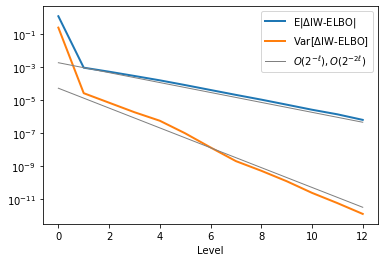

In [53]:
L=13
conv_stats = [conv_stats_dIWELBO(l, model, beta0, beta, alpha) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

# plot results
plt.plot(conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO']], linewidth=2)

# plot O(2^{-l/2}), O(2^{-l}), O(2^{-2l})
s,t = conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO']].iloc[1]
plt.plot(s*2.**(1-np.arange(L)), c='grey', linewidth=1)
plt.plot(t*2.**(1-np.arange(L)*2), c='grey', linewidth=1)

plt.legend([r'$\mathrm{E} | \Delta \mathrm{IW}$-$\mathrm{ELBO}|$', 
            r'$\mathrm{Var}[\Delta \mathrm{IW}$-$\mathrm{ELBO}]$', 
            r'$O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [52]:
# compute cost-variance efficiency of MLMC 
C = [1 if l==0 else 2**(l+1) for l in range(L)]
V = conv_stats['var_dIWELBO']
N = np.sqrt(V/C)
cost_mlmc = [np.sum([np.sqrt(c*v) for c,v in zip(C[:l+1], V[:l+1])])**2  for l in range(L)]
cost_nmc = [2**l * v for l,v in enumerate(conv_stats['var_IWELBO'])]

(Theoretical) Variance per Reciprocal Complexity and N_l's for MLMC


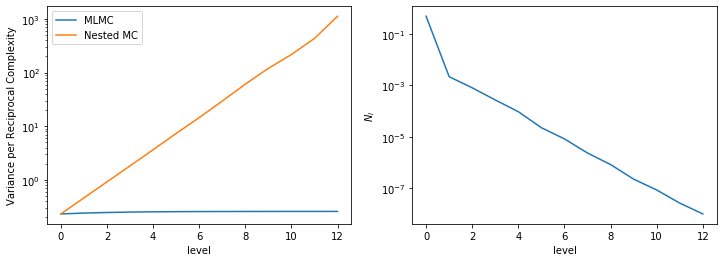

In [53]:
plt.figure(figsize=[12,4])
# plot theoretical computational efficiency
plt.subplot(1,2,1)
plt.plot(cost_mlmc)
plt.plot(cost_nmc)
plt.yscale('log')
plt.ylabel('Variance per Reciprocal Complexity')
plt.xlabel('level')
plt.legend(['MLMC', 'Nested MC'])
# plot N_l's for MLMC
plt.subplot(1,2,2)
plt.plot(N)
plt.yscale('log')
plt.ylabel(r'$N_l$')
plt.xlabel('level')
print('(Theoretical) Variance per Reciprocal Complexity and N_l\'s for MLMC')

In [54]:
conv_stats

,mean_dIWELBO,mean_abs_dIWELBO,mean_squared_dIWELBO,var_dIWELBO,var_IWELBO
0,-1.252914e+00,1.252959e+00,1.801901e+00,2.321084e-01,0.232108
1,7.659012e-04,7.659012e-04,1.928202e-05,1.869541e-05,0.230994
2,4.296648e-04,4.296648e-04,5.297300e-06,5.112689e-06,0.229762
3,2.353968e-04,2.353968e-04,1.215908e-06,1.160497e-06,0.228204
4,1.272100e-04,1.272100e-04,3.021725e-07,2.859902e-07,0.228002
5,6.391666e-05,6.391666e-05,3.656841e-08,3.248307e-08,0.229570
6,3.313349e-05,3.313349e-05,9.886079e-09,8.788250e-09,0.226590
7,1.687736e-05,1.687736e-05,1.686501e-09,1.401656e-09,0.230252
8,8.531222e-06,8.531222e-06,4.300854e-10,3.573037e-10,0.238437
9,4.047158e-06,4.047158e-06,6.894719e-11,5.256771e-11,0.235069


## MLMC codition check for gradients

In [99]:
params = [
    model.beta0, 
    model.beta,
    model.alpha
]

def conv_stats_grad_dIWELBO(level, model, beta0, beta, alpha):
    # Compute the gradient of dIWELBO (and IWELBO) for each sample and 
    # summarize them into several statistics.

    print("evaluating the gradients of dIWELBO at level {}".format(level))

    N0 = 2000000
    N = N0//2**level
    n_MC = 2**level
    x,y,_ = generate_data(N=N, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    
    q_param = model.laplace_approx(x, y)
    mu  = q_param['mu']
    sigma = q_param['sigma']
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N]).T

    # Define a gradient function to be vectorized (vectorization for better performance)
    def get_grad(args):
        # get gradient of dIWELBO (and IWELBO) given one sample
        x_, y_, z_, mu, sigma = args
        q_param = {'mu':mu, 'sigma':sigma}
        z_ = tf.reshape(z_, [-1,1])
        with tf.GradientTape(persistent=True) as g:
            g.watch(params)
            diwelbos = model.pointwise_dIWELBO(x_, y_, z_, q_param)
            iwelbos = model.pointwise_IWELBO(x_, y_, z_, q_param)    
        a = g.gradient(diwelbos, params)
        b = g.gradient(iwelbos, params)
        del g
        return a,b
    
    # Compute the gradient of dIWELBO (and IWELBO) for each sample
    args = [tf.expand_dims(arg, axis=1) for arg in [x, y, z, mu, sigma]]
    grads = tf.vectorized_map(get_grad, args)
        
    grad_diwelbos = tf.concat([
        tf.expand_dims(g,1) if len(g.shape)<2 else g 
        for g in grads[0]
    ], axis=1)#[:D+1]
    grad_iwelbos = tf.concat([
        tf.expand_dims(g,1) if len(g.shape)<2 else g 
        for g in grads[1]
    ], axis=1)#[:D+1]
    
    # return summary statistics of the gradients
    return {'norm_mean_grad_dIWELBO': np.linalg.norm(np.mean(grad_diwelbos, axis=0)), 
            'mean_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)), 
            'mean_squared_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)**2),
            'trace_covariance_grad_dIWELBO': np.sum(np.var(grad_diwelbos, axis=0)), 
            'trace_covariance_grad_IWELBO': np.sum(np.var(grad_iwelbos, axis=0))}

In [100]:
L=13
conv_stats = [conv_stats_grad_dIWELBO(l, model, beta0, beta, alpha) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

evaluating the gradients of dIWELBO at level 0
evaluating the gradients of dIWELBO at level 1
evaluating the gradients of dIWELBO at level 2
evaluating the gradients of dIWELBO at level 3
evaluating the gradients of dIWELBO at level 4
evaluating the gradients of dIWELBO at level 5
evaluating the gradients of dIWELBO at level 6
evaluating the gradients of dIWELBO at level 7
evaluating the gradients of dIWELBO at level 8
evaluating the gradients of dIWELBO at level 9
evaluating the gradients of dIWELBO at level 10
evaluating the gradients of dIWELBO at level 11
evaluating the gradients of dIWELBO at level 12


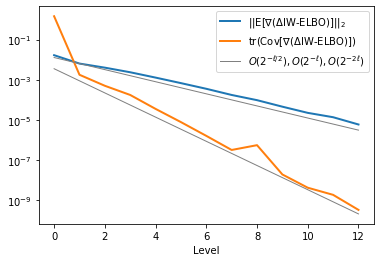

In [104]:
# plot results
plt.plot(conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO']], linewidth=2)

# plot O(2^{-l/2}), O(2^{-l}), O(2^{-2l})
s,t = conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO']].iloc[1]
plt.plot(s*2.**(1-np.arange(L)), c='grey', linewidth=1)
plt.plot(t*2.**(1-np.arange(L)*2), c='grey', linewidth=1)

plt.legend([r'$||\mathrm{E} [\nabla (\Delta \mathrm{IW}$-$\mathrm{ELBO})]||_2$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\nabla(\Delta \mathrm{IW}$-$\mathrm{ELBO})])$',
            r'$O(2^{-\ell/2}), O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [ ]:
# compute cost-variance efficiency of MLMC 
C = [1 if l==0 else 2**(l+1) for l in range(L)]
V = conv_stats['trace_covariance_grad_dIWELBO']
N = np.sqrt(V/C)
cost_mlmc = [np.sum([np.sqrt(c*v) for c,v in zip(C[:l+1], V[:l+1])])**2  for l in range(L)]
cost_nmc = [2**l * v for l,v in enumerate(conv_stats['trace_covariance_grad_IWELBO'])]

In [ ]:
plt.figure(figsize=[12,4])
# plot theoretical computational efficiency
plt.subplot(1,2,1)
plt.plot(cost_mlmc)
plt.plot(cost_nmc)
plt.yscale('log')
plt.ylabel('Variance per Reciprocal Complexity')
plt.xlabel('level')
plt.legend(['MLMC', 'Nested MC'])
# plot N_l's for MLMC
plt.subplot(1,2,2)
plt.plot(N)
plt.yscale('log')
plt.ylabel(r'$N_l$')
plt.xlabel('level')
print('(Theoretical) Variance per Reciprocal Complexity and N_l\'s for MLMC')

In [ ]:
conv_stats

In [ ]:
def conv_stats_dSUMO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    # Compute dIWELBO (and IWELBO) for each sample and 
    # summarize them into several statistics.

    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    dsumos = 0
    dsumos += pointwise_IWELBO(x, y, z[ :,:], beta0, beta, alpha, mu, sigma).numpy()
    dsumos -= pointwise_IWELBO(x, y, z[1:,:], beta0, beta, alpha, mu, sigma).numpy()
    
    dN = N//10
    var_sumos = dN * np.var([
        IWELBO_SUMO(
            x[dN*i:dN*(i+1)], y[dN*i:dN*(i+1)], beta0, beta, alpha,
            mu[dN*i:dN*(i+1)], sigma[dN*i:dN*(i+1)], K_max=2**level
            ) 
        for i in range(10)])
    
    return {'mean_dSUMO':np.mean(dsumos), 
            'mean_abs_dSUMO':np.mean(np.abs(dsumos)), 
            'mean_squared_dSUMO':np.mean(dsumos**2),
            'var_dSUMO':np.var(dsumos),
            'var_SUMO':var_sumos}

In [ ]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_dSUMO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=13
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

In [ ]:
# plot results
plt.plot(conv_stats[['mean_abs_dSUMO', 'var_dSUMO', 'var_SUMO']])

# plot O(2^{-l/2}), O(2^{-l}), O(2^{-2l})
s,t = conv_stats[['mean_abs_dSUMO', 'var_dSUMO']].iloc[1]
plt.plot(s*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$\mathrm{E}  |\Delta^{\mathrm{SUMO}}_{2^{\ell}}|$', 
            r'$\mathrm{Var}[\Delta^{\mathrm{SUMO}}_{2^{\ell}}]$', 
            r'$\mathrm{Var}[\mathrm{SUMO}_{2^{\ell}}]$', 
            r'$O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [ ]:
conv_stats

## Cost comparison of objective

In [ ]:
L = 13
objectives = {
    'NMC':      lambda x,y,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.95, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.95, b=1.8, randomize=True),
    'SUMO':     lambda x,y,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}
results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( obj(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        if level>10 and name=='NMC':
            start = time.time()
            obj(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            obj(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

In [ ]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel('Variance per Reciprocal Runtime')
plt.yscale('log')

Variance per "reciprocal of the runtime" is considered because the varince is propotional to the  "reciprocal of the runtime". As we increase the computational complexity (runtime), the decrease in varince is inversely propotional to the complexity. 

## Cost comparison of gradients

In [113]:
L = 13
objectives = {
    'NMC':      lambda x,y,level: model.IWELBO(x, y, n_MC=2**level),
    'MLMC':     lambda x,y,level: model.IWELBO_MLMC(x, y, max_level=level, randomize=False),
    'RandMLMC': lambda x,y,level: model.IWELBO_MLMC(x, y, max_level=level, randomize=True),
    'SUMO':     lambda x,y,level: model.IWELBO_SUMO(x, y, K_max=2**level)
}

def d(f):
    # Take the derivative of f
    # returned value is a function df/d[beta0, beta, alpha]
    def df(x,y,level):
        with tf.GradientTape(persistent=True) as g:
            g.watch(params)
            target = f(x,y,level)
        est0 = g.gradient(target, params)
        est = np.concatenate([e.numpy().reshape([-1]) for e in est0], axis=0)
        return est
    return df

results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        for level in range(L):
            results[name][i].append( d(obj)(x,y,level) )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    for level in range(L):
        # Avoid the memery runout by 
        # manipulating the case of NMC with large n_MC (large level)
        if level>10 and name=='NMC':
            start = time.time()
            d(obj)(*[vec[:200] for vec in [x,y]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            d(obj)(x,y,level)
            end = time.time()
            runtime[name].append(end - start)

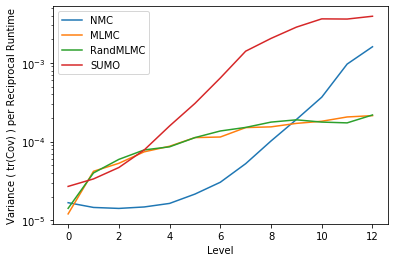

In [114]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0).sum(axis=1) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel(r'Variance ( tr(Cov) ) per Reciprocal Runtime')
plt.yscale('log')